In [0]:
import numpy as np
import time, math
import cv2
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe

import matplotlib.pyplot as plt
% matplotlib inline

In [0]:
learning_rate = 0.4 
epochs = 25
batch_size = 512
end_percentage = 0.05
triangle_tilt = 0.7

In [3]:
# Loading the CIFAR10 60000 Training and 10000 Test data into respective numpy arrays
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

n_train, n_test = X_train.shape[0], X_test.shape[0]
img_size = X_train.shape[1]
n_classes = y_train.max() + 1

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
Y_train = tf.keras.utils.to_categorical(y_train, n_classes)
Y_test = tf.keras.utils.to_categorical(y_test, n_classes)

In [5]:
X_train_mean = np.mean(X_train, axis=(0,1,2))
X_train_std = np.std(X_train, axis=(0,1,2))
print(X_train_mean, X_train_std)

[0.4914009  0.48215896 0.4465308 ] [0.24703279 0.24348423 0.26158753]


In [6]:
X_test_mean = np.mean(X_test, axis=(0,1,2))
X_test_std = np.std(X_test, axis=(0,1,2))
print(X_test_mean, X_test_std)

[0.49421427 0.4851322  0.45040992] [0.24665268 0.24289216 0.2615922 ]


In [0]:
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_test_mean) / X_test_std

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(validation_iterator, test_y, model):
    result = model.evaluate_generator(validation_iterator, steps = len(validation_iterator))
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def show_examples(X,y,classes):
    rows = int(np.ceil(len(X)/5))
    if X.shape[1] > 64:
        multiplier = 2
    else:
        multiplier = 1
    fig = plt.figure(figsize=(10*multiplier, rows*2*multiplier))
    for idx in np.arange(len(X)):
        img = X[idx]
        assert (len(img.shape)==3 and img.shape[2] in [1,3,4]) or len(img.shape)==2
        ax = fig.add_subplot(rows, 5, idx + 1, xticks=[], yticks=[])
        cmap = None
        if (len(img.shape)==3 and img.shape[2]==1) or len(img.shape)==2:
            cmap="binary"
        if len(img.shape)==3 and img.shape[2]==1:
            img = img.reshape((img.shape[0],img.shape[1]))
        ax.imshow(img,cmap=cmap)
        ax.set_title(classes[np.argmax(y[idx])])
    plt.show()

In [0]:
def get_cifar10_labels():
    return ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [0]:
def min_max_scale(X):
  return (X - np.min(X))/(np.max(X)-np.min(X))

In [0]:
def get_cutout_eraser_and_padcrop(p=0.5, s_l=0.3, s_h=0.3, r_1=0.3, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=True, random_crop_size=(32, 32), padding_pixels=4):
    """
    :param p:
    :param s_l: Minimum Area Proportion of Original that may be cut
    :param s_h: Maximum Area Proportion of Original that may be cut
    :param r_1: Min Aspect Ratio
    :param r_2: Max Aspect Ratio
    :param max_erasures_per_image:
    :param pixel_level:
    :return: Eraser to be used as Preprocessing Function
    """
    assert max_erasures_per_image >= 1

    def eraser(input_img):
        v_l = np.min(input_img)
        v_h = np.max(input_img)
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        mx = np.random.randint(1, max_erasures_per_image + 1)
        # print("Erasures = ",mx,end =", ")
        for i in range(mx):
            while True:
                s = np.random.uniform(s_l, s_h) * img_h * img_w
                r = np.random.uniform(r_1, r_2)
                w = int(np.sqrt(s / r))
                h = int(np.sqrt(s * r))
                left = np.random.randint(0, img_w)
                top = np.random.randint(0, img_h)

                if left + w <= img_w and top + h <= img_h:
                    break

            # print("W = ",w,"H = ",h,end =", ")

            if pixel_level:
                # print(np.max(img_c),np.min(img_c),v_l,v_h)
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
                # print(c.shape,np.min(c),np.max(c),np.median(c))
            else:
                c = np.random.uniform(v_l, v_h)

            input_img[top:top + h, left:left + w, :] = c

        # print()
        return input_img
     
    def random_crop(input_image):
          # Note: image_data_format is 'channel_last'
          assert input_image.shape[2] == 3
          
          #Pad by 4 pixels
          img = cv2.copyMakeBorder(input_image, padding_pixels, padding_pixels, padding_pixels, padding_pixels, cv2.BORDER_REPLICATE)
          
          height, width = img.shape[0], img.shape[1]
          dy, dx = random_crop_size
          x = np.random.randint(0, width - dx + 1)
          y = np.random.randint(0, height - dy + 1)
          return img[y:(y+dy), x:(x+dx), :]
        
    def preproc_image(input_image):
      #return eraser
      return eraser(random_crop(input_image))

    return preproc_image
      
        

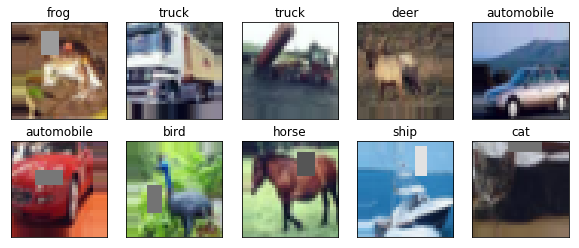

In [14]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
   #featurewise_center=True,
   #featurewise_std_normalization=True,
   horizontal_flip=0.5,                 # randomly flip images                                     
   preprocessing_function=get_cutout_eraser_and_padcrop(p=0.5, s_l=0.05, s_h=0.05, r_1=0.2, r_2=1 / 0.3, max_erasures_per_image=1, pixel_level=False))

_ = datagen.fit(X_train)
train_iterator = datagen.flow(X_train, Y_train, batch_size=batch_size, shuffle=False)

X_e, Y_e = train_iterator.next()
X_e = min_max_scale(X_e)
show_examples(X_e[0:10], Y_e[0:10], classes = get_cifar10_labels())

In [0]:
datagen_validation = tf.keras.preprocessing.image.ImageDataGenerator()
datagen_validation.fit(X_test)
validation_iterator = datagen_validation.flow(X_test, Y_test, batch_size=batch_size, shuffle=False)

In [0]:
input_shape=(32, 32, 3)
num_outputs = 10

In [17]:
#Define DawnNet model
input = tf.keras.layers.Input(shape=input_shape)

prep = tf.keras.layers.Conv2D(filters=32,
                          kernel_size=(3, 3),
                          strides=(1, 1),
                          padding="same",
                          #kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)
prep = tf.keras.layers.BatchNormalization(axis=3,momentum=0.9, epsilon=1e-5)(prep)
prep = tf.keras.layers.Activation("relu")(prep)

layer1 = tf.keras.layers.Conv2D(filters=64,
                          kernel_size=(3, 3),
                          strides=(1, 1),
                          padding="same",
                          #kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(prep)
layer1 = tf.keras.layers.BatchNormalization(axis=3,momentum=0.9, epsilon=1e-5)(layer1)
layer1 = tf.keras.layers.Activation("relu")(layer1)
layer1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(layer1)

layer1_res1_identity = tf.keras.layers.Conv2D(filters=32,
                          kernel_size=(1, 1),
                          strides=(1, 1),
                          padding="same",
                          #kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(layer1)
layer1_res1 = tf.keras.layers.Conv2D(filters=64,
                          kernel_size=(3, 3),
                          strides=(1, 1),
                          padding="same",
                          #kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(layer1_res1_identity)
layer1_res1 = tf.keras.layers.BatchNormalization(axis=3,momentum=0.9, epsilon=1e-5)(layer1_res1)
layer1_res1 = tf.keras.layers.Activation("relu")(layer1_res1)

#concat1 = tf.keras.layers.concatenate([layer1, layer1_res1])

layer1_res2 = tf.keras.layers.Conv2D(filters=64,
                          kernel_size=(3, 3),
                          strides=(1, 1),
                          padding="same",
                          #kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(layer1_res1)
layer1_res2 = tf.keras.layers.BatchNormalization(axis=3,momentum=0.9, epsilon=1e-5)(layer1_res2)
layer1_res2 = tf.keras.layers.Activation("relu")(layer1_res2)

concat1 = tf.keras.layers.concatenate([layer1, layer1_res2])


layer2 = tf.keras.layers.Conv2D(filters=128,
                          kernel_size=(3, 3),
                          strides=(1, 1),
                          padding="same",
                          #kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(concat1)
layer2 = tf.keras.layers.BatchNormalization(axis=3,momentum=0.9, epsilon=1e-5)(layer2)
layer2 = tf.keras.layers.Activation("relu")(layer2)
layer2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(layer2)


layer3 = tf.keras.layers.Conv2D(filters=256,
                          kernel_size=(3, 3),
                          strides=(1, 1),
                          padding="same",
                          #kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(layer2)
layer3 = tf.keras.layers.BatchNormalization(axis=3,momentum=0.9, epsilon=1e-5)(layer3)
layer3 = tf.keras.layers.Activation("relu")(layer3)
layer3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(layer3)

layer3_res1_identity = tf.keras.layers.Conv2D(filters=128,
                          kernel_size=(1, 1),
                          strides=(1, 1),
                          padding="same",
                          #kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(layer3)
layer3_res1 = tf.keras.layers.Conv2D(filters=256,
                          kernel_size=(3, 3),
                          strides=(1, 1),
                          padding="same",
                          #kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(layer3_res1_identity)
layer3_res1 = tf.keras.layers.BatchNormalization(axis=3,momentum=0.9, epsilon=1e-5)(layer3_res1)
layer3_res1 = tf.keras.layers.Activation("relu")(layer3_res1)

layer3_res2 = tf.keras.layers.Conv2D(filters=256,
                          kernel_size=(3, 3),
                          strides=(1, 1),
                          padding="same",
                          #kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(layer3_res1)
layer3_res2 = tf.keras.layers.BatchNormalization(axis=3,momentum=0.9, epsilon=1e-5)(layer3_res2)
layer3_res2 = tf.keras.layers.Activation("relu")(layer3_res2)

concat2 = tf.keras.layers.concatenate([layer3, layer3_res2])

gmp = tf.keras.layers.GlobalMaxPooling2D()(concat2)
dense = tf.keras.layers.Dense(units=num_outputs, activation="softmax")(gmp) #kernel_initializer="he_normal", 

model = tf.keras.models.Model(inputs=input, outputs=dense)

W0815 17:18:21.054956 139670874630016 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

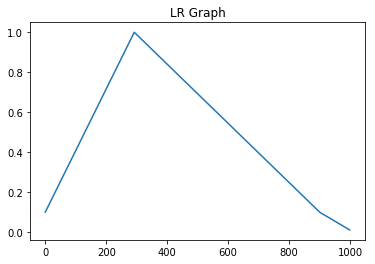

In [19]:
def min_max_scaler(iterations, num_iterations, end_percentage, min_val, max_val, invert = False, triangle_tilt = 0.65):
  non_slant_mid_cycle_id = int(num_iterations * ((1. - end_percentage)) / float(2))
  mid_cycle_id = int(triangle_tilt*int(num_iterations * ((1. - end_percentage)) / float(2)))
  value = 0
  if iterations > 2 * non_slant_mid_cycle_id:
    
    
      extra_iters = (iterations - 2 * non_slant_mid_cycle_id)
      current_percentage = 1 - (1 - 1/10)*extra_iters/(num_iterations - 2 * non_slant_mid_cycle_id)
            

  elif iterations >  mid_cycle_id:
      current_percentage = 1. - (iterations - mid_cycle_id) / (2*non_slant_mid_cycle_id - mid_cycle_id)
      
  else:
      current_percentage = iterations / mid_cycle_id
      
  if invert:
    if iterations > 2 * non_slant_mid_cycle_id:
      return max_val
    return max_val - current_percentage * (max_val - min_val)
  else:
    if iterations > 2 * non_slant_mid_cycle_id:
      return min_val * current_percentage
    return min_val + current_percentage * (max_val - min_val)
  
    

print("="*80)
scales = []
for i in range(1000):
  p = min_max_scaler(i,1000,0.1,min_val=0.1,max_val=1, invert=False)
  scales.append(p)
  
plt.plot(np.array(scales))
plt.title("LR Graph")
plt.show()

In [0]:
import os
import numpy as np
import warnings

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)


# Code is ported from https://github.com/fastai/fastai
class OneCycleLR(Callback):
    def __init__(self,
                 epochs,
                 batch_size,
                 samples,
                 steps,
                 max_lr,
                 end_percentage=0.1,
                 scale=100,
                 maximum_momentum=0.95,
                 minimum_momentum=0.85,
                 triangle_tilt = 0.75,
                 verbose=True):
        """ This callback implements a cyclical learning rate policy (CLR).
        This is a special case of Cyclic Learning Rates, where we have only 1 cycle.
        After the completion of 1 cycle, the learning rate will decrease rapidly to
        100th its initial lowest value.
        # Arguments:
            max_lr: Float. Initial learning rate. This also sets the
                starting learning rate (which will be 10x smaller than
                this), and will increase to this value during the first cycle.
            end_percentage: Float. The percentage of all the epochs of training
                that will be dedicated to sharply decreasing the learning
                rate after the completion of 1 cycle. Must be between 0 and 1.
            scale_percentage: Float or None. If float, must be between 0 and 1.
                If None, it will compute the scale_percentage automatically
                based on the `end_percentage`.
            maximum_momentum: Optional. Sets the maximum momentum (initial)
                value, which gradually drops to its lowest value in half-cycle,
                then gradually increases again to stay constant at this max value.
                Can only be used with SGD Optimizer.
            minimum_momentum: Optional. Sets the minimum momentum at the end of
                the half-cycle. Can only be used with SGD Optimizer.
            verbose: Bool. Whether to print the current learning rate after every
                epoch.
        # Reference
            - [A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, weight_decay, and weight decay](https://arxiv.org/abs/1803.09820)
            - [Super-Convergence: Very Fast Training of Residual Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120)
        """
        super(OneCycleLR, self).__init__()

        if end_percentage < 0. or end_percentage > 1.:
            raise ValueError("`end_percentage` must be between 0 and 1")


        self.initial_lr = max_lr
        self.end_percentage = end_percentage
        self.scale = scale
        self.max_momentum = maximum_momentum
        self.min_momentum = minimum_momentum
        self.verbose = verbose

        if self.max_momentum is not None and self.min_momentum is not None:
            self._update_momentum = True
        else:
            self._update_momentum = False

        self.clr_iterations = 0.
        self.history = {}

        self.epochs = epochs
        self.batch_size = batch_size
        self.samples = samples
        self.steps = steps
        self.num_iterations = None
        self.mid_cycle_id = None

    def _reset(self):
        """
        Reset the callback.
        """
        self.clr_iterations = 0.
        self.history = {}

    def compute_lr(self):
        """
        Compute the learning rate based on which phase of the cycle it is in.
        - If in the first half of training, the learning rate gradually increases.
        - If in the second half of training, the learning rate gradually decreases.
        - If in the final `end_percentage` portion of training, the learning rate
            is quickly reduced to near 100th of the original min learning rate.
        # Returns:
            the new learning rate
        """
        new_lr = min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.initial_lr/self.scale, self.initial_lr, invert = False, triangle_tilt=triangle_tilt)
        return new_lr

    def compute_momentum(self):
        """
         Compute the momentum based on which phase of the cycle it is in.
        - If in the first half of training, the momentum gradually decreases.
        - If in the second half of training, the momentum gradually increases.
        - If in the final `end_percentage` portion of training, the momentum value
            is kept constant at the maximum initial value.
        # Returns:
            the new momentum value
        """    
        new_momentum = min_max_scaler(self.clr_iterations, self.num_iterations, self.end_percentage, self.min_momentum, self.max_momentum, invert = True, triangle_tilt=triangle_tilt)
        return new_momentum

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.steps is not None:
            self.num_iterations = self.epochs * self.steps
        else:
            if (self.samples % self.batch_size) == 0:
                remainder = 0
            else:
                remainder = 1
            self.num_iterations = (self.epochs + remainder) * self.samples // self.batch_size

        self.mid_cycle_id = int(self.num_iterations * ((1. - self.end_percentage)) / float(2))

        self._reset()
        K.set_value(self.model.optimizer.lr, self.compute_lr())

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()
            K.set_value(self.model.optimizer.momentum, new_momentum)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}

        self.clr_iterations += 1
        new_lr = self.compute_lr()

        self.history.setdefault('lr', []).append(
            K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

        if self._update_momentum:
            if not hasattr(self.model.optimizer, 'momentum'):
                raise ValueError("Momentum can be updated only on SGD optimizer !")

            new_momentum = self.compute_momentum()

            self.history.setdefault('momentum', []).append(
                K.get_value(self.model.optimizer.momentum))
            K.set_value(self.model.optimizer.momentum, new_momentum)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            if self._update_momentum:
                print(" - lr: %0.5f - momentum: %0.2f " %
                      (self.history['lr'][-1], self.history['momentum'][-1]))

            else:
                print(" - lr: %0.5f " % (self.history['lr'][-1]))
                
    
    def plot(self):
        plt.title("LR-Plot")
        plt.plot(self.history['lr'])
        plt.xlabel("Epochs")
        plt.ylabel("LR")
        plt.show()
        
        plt.title("Momentum-Plot")
        plt.plot(self.history['momentum'])
        plt.xlabel("Epochs")
        plt.ylabel("Momentum")
        plt.show()

In [0]:
class StopAtAccValue(Callback):
  def __init__(self,validation_iterator, threshold = 0.9, ):
    super(StopAtAccValue, self).__init__()
    self.threshold = threshold
    self.validation_iterator = validation_iterator
  def on_epoch_end(self, epoch, logs={}):
    score = self.model.evaluate_generator(self.validation_iterator,steps=len(self.validation_iterator))
    acc = score[1]
    if acc >= self.threshold:
      self.model.stop_training = True
      print("Stopping Training:: Val Acc = %.3f Achieved"%(acc))
    else:
      print("Continue Training:: Val Acc = %.3f, Threshold = %.3f"%(acc,self.threshold))

In [0]:
olr = OneCycleLR(epochs=epochs, batch_size = batch_size,steps=len(train_iterator), 
                 samples=X_train.shape[0], max_lr=learning_rate, verbose = True, scale = 50, end_percentage=end_percentage,
                 maximum_momentum = 0.95, minimum_momentum=0.85, triangle_tilt=triangle_tilt)

In [0]:
sgd = tf.keras.optimizers.SGD(lr=0.0018, decay=5e-4, momentum=0.9, nesterov=True)

# Compile the model
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Specifying the path to store the weights
#filepath="/content/gdrive/My Drive/Assignment13_v3.4.hdf5"
filepath = "/content/model.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='max')

In [0]:
stopper = StopAtAccValue(validation_iterator, threshold = 0.94)

In [0]:
callbacks = [olr]

Epoch 1/25
 - lr: 0.05471 - momentum: 0.94 
98/98 - 21s - loss: 2.2221 - acc: 0.3709 - val_loss: 1.6693 - val_acc: 0.4849
Epoch 2/25
 - lr: 0.10191 - momentum: 0.93 
98/98 - 12s - loss: 1.4554 - acc: 0.5473 - val_loss: 1.3262 - val_acc: 0.6037
Epoch 3/25
 - lr: 0.14910 - momentum: 0.91 
98/98 - 12s - loss: 1.0649 - acc: 0.6750 - val_loss: 0.8657 - val_acc: 0.7429
Epoch 4/25
 - lr: 0.19629 - momentum: 0.90 
98/98 - 12s - loss: 0.8818 - acc: 0.7367 - val_loss: 0.9741 - val_acc: 0.7260
Epoch 5/25
 - lr: 0.24349 - momentum: 0.89 
98/98 - 12s - loss: 0.7955 - acc: 0.7743 - val_loss: 0.7485 - val_acc: 0.7866
Epoch 6/25
 - lr: 0.29068 - momentum: 0.88 
98/98 - 12s - loss: 0.7153 - acc: 0.7994 - val_loss: 0.8049 - val_acc: 0.7756
Epoch 7/25
 - lr: 0.33788 - momentum: 0.87 
98/98 - 12s - loss: 0.6681 - acc: 0.8180 - val_loss: 0.7001 - val_acc: 0.8064
Epoch 8/25
 - lr: 0.38507 - momentum: 0.85 
98/98 - 12s - loss: 0.6357 - acc: 0.8308 - val_loss: 0.6885 - val_acc: 0.8220
Epoch 9/25
 - lr: 0.3826

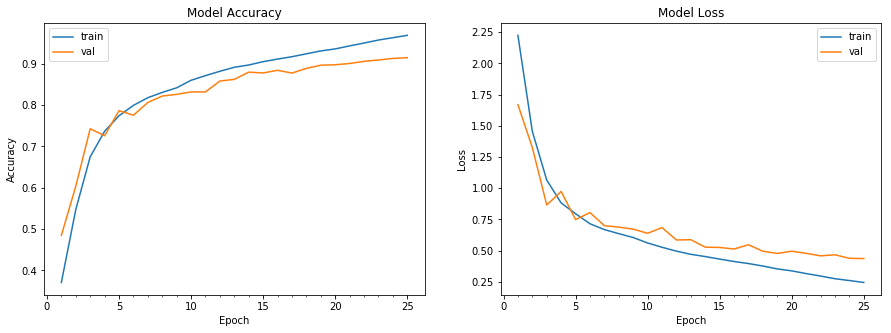

In [27]:
# train the model
start = time.time()
# Train the model

model_info = model.fit_generator(train_iterator,
                                 steps_per_epoch = len(train_iterator), epochs = epochs, 
                                 validation_data = validation_iterator, 
                                 validation_steps = len(validation_iterator),
                                 verbose=2, callbacks=callbacks)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

In [28]:
# compute test accuracy
result = model.evaluate_generator(validation_iterator, steps = len(validation_iterator))
print(result)

[0.43652025163173674, 0.9149]


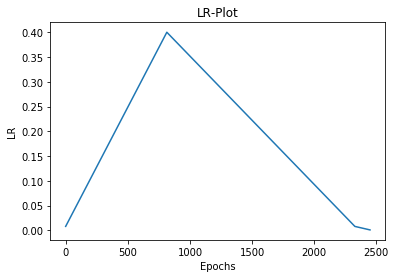

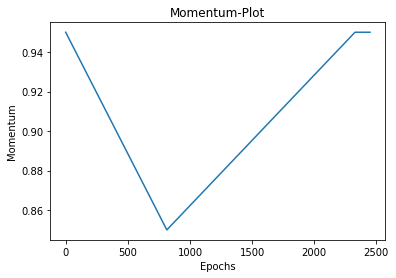

In [29]:
layer = [layer for layer in model.layers[0:] if type(layer)==Conv2D][-2]
olr.plot()